## Boosted stumps 

In [54]:
import pandas as pd 
import numpy as np

from scipy.optimize import minimize 

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from tabulate import tabulate 

%matplotlib inline
%store -r folds_performance
%store -r model_reliance

In [56]:
train_pd = pd.read_csv("ada_train.csv")
test_pd = pd.read_csv("ada_test.csv")

train_np, test_np = np.array(train_pd), np.array(test_pd)
train_np[train_np == 0] = -1
test_np[test_np==0]=-1
X_train, Y_train = train_np[:,1:], train_np[:,0]
X_test, Y_test = test_np[:,1:], test_np[:,0]
print(X_test.shape)



(373, 77)


In [59]:
print(train_pd.columns.tolist())

['recid_use', 'p_charge1', 'p_charge3', 'p_charge5', 'p_charge7', 'p_charge9', 'p_jail30_1', 'p_jail30_3', 'p_jail30_5', 'p_jail30_7', 'p_jail30_9', 'p_prison1', 'p_prison3', 'p_prison5', 'p_prison7', 'p_prison9', 'p_probation1', 'p_probation3', 'p_probation5', 'p_probation7', 'p_probation9', 'p_juv_fel_count1', 'p_juv_fel_count3', 'p_juv_fel_count5', 'p_juv_fel_count7', 'p_juv_fel_count9', 'p_felprop_violarrest1', 'p_felprop_violarrest3', 'p_felprop_violarrest5', 'p_felprop_violarrest7', 'p_felprop_violarrest9', 'p_murder_arrest1', 'p_murder_arrest3', 'p_murder_arrest5', 'p_murder_arrest7', 'p_murder_arrest9', 'p_felassault_arrest1', 'p_felassault_arrest3', 'p_felassault_arrest5', 'p_felassault_arrest7', 'p_felassault_arrest9', 'p_misdemassault_arrest1', 'p_misdemassault_arrest3', 'p_misdemassault_arrest5', 'p_misdemassault_arrest7', 'p_misdemassault_arrest9', 'p_famviol_arrest1', 'p_famviol_arrest3', 'p_famviol_arrest5', 'p_famviol_arrest7', 'p_famviol_arrest9', 'p_weapons_arrest1', 

In [37]:
def AdaBoost_train(X, Y, T):
    '''
    @param X: n x p np array
    @param Y: labels for X, y \in {-1,1}
    @param T: number iterations
    returns: a p x 1 vector of weights on each feature
    '''
#     Duplicate dataset with negative features for AdaBoost 
#     X = np.concatenate([X_train, -X_train], axis = 1 )

    # d_t should be n x 1 vector
    # alpha should be T x 1 vector (weight for each weak classifier)
    n, p = X.shape[0], X.shape[1]
    d = np.ones(n)* (1/n)
    
    def featureClassifier(X, Y, n, p, d):
        '''
        All features above are binary
        Returns the index of the feature which performs best as a classifier
        '''
        weighted_error  = np.ones(p)
        all_misclass = []
        for j in range(p):
            #compute misclassification errotr
            misclass = np.array([1 if Y[i]!= X[i,j] else 0 for i in range(n)]) #ones vector s.t. label col != feature j
            #record weighted error for jth feature
            weighted_error[j] = np.dot(misclass, d)
            all_misclass.append(misclass)
        #pick the jth feature which minimizes the weighted misclassification error
        best_j, error_j = np.argmin(weighted_error), np.min(weighted_error)
        return best_j, error_j, all_misclass[best_j]
     
    alphas, classifier_inds = np.zeros(T), np.zeros(T)

    for t in range(T):
        if t%200 == 0: print("t = ", t)
        best_j, epsilon, misclass = featureClassifier(X,Y,n,p,d)
        #compute weights on weak classifiers 
        alpha = .5 * np.log((1-epsilon)/epsilon)
        alphas[t] = alpha
        classifier_inds[t] = best_j
        
        #update weights on points
        misclass_inds, correct_inds = np.argwhere(misclass == 1), np.argwhere(misclass == 0)
        d[misclass_inds] *= np.exp(alpha) 
        d[correct_inds] *= np.exp(-alpha) 
#         perform normalization
        Z = np.sum(d)
        d = d/Z
    #compute weights on each feature from alphas 
    
    feat_weights = np.zeros(p)
    for i,classifier_ind in enumerate(classifier_inds): 
        feat_weights[int(classifier_ind)] += alphas[i]
        
    return feat_weights 

T = 1000
feat_weights = AdaBoost_train(X_train,Y_train, T)

t =  0
t =  200
t =  400
t =  600
t =  800


In [46]:
def AdaBoost_predict(X, feat_weights, threshold = .5):
    '''
    Converts AdaBoost predictions to probabilities and outputs a class 
    @param X: np array of data to predict on 
    @param alphas: weights on each feature 
    @param classifier_inds: indices of the features we use as weak classifiers
    '''
#     def AdaBoost_billweights(feat_weights): 
#         '''
#         Accumulate AdaBoost weights on the doubled dataset (with "negative" bills) so that there are only 16 weights.
#         '''
#         ada_bill_weights = []
#         for i in range(77): 
#             ada_bill_weights.append(feat_weights[i] - feat_weights[i+77])
#         return np.array(ada_bill_weights)
    
#     bill_weights = AdaBoost_billweights(feat_weights)

    raw = X @ feat_weights
    probas = np.exp(2*raw) / (1 + np.exp(2*raw))
    #threshold probabilities to get a class
    preds = np.copy(probas)
    preds[probas > threshold] = 1
    preds[probas <= threshold] = -1
    return probas, preds 
    
def AdaBoost_accuracy(X_train, Y_train, X_test, Y_test, feat_weights, threshold = .5):
    '''Computes training and test accuracy using weak classifiers from AdaBoost_train. '''
    
    train_probas,train_preds = AdaBoost_predict(X_train, feat_weights, threshold)
    test_probas, test_preds = AdaBoost_predict(X_test, feat_weights, threshold)
    #percent correctly classified
    train_acc =  sum([1 for i in range(len(Y_train)) if train_preds[i] == Y_train[i] ])/len(Y_train) 
    test_acc =  sum([1 for i in range(len(Y_test)) if test_preds[i] == Y_test[i] ])/len(Y_test)
    return train_acc, test_acc

train_acc, test_acc = AdaBoost_accuracy(X_train, Y_train, X_test, Y_test, feat_weights)
print("Train accuracy is ", train_acc, "\nTest accuracy is ", test_acc)

Train accuracy is  0.6356749311294766 
Test accuracy is  0.628099173553719


In [7]:
#testing logistic regresesion 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, Y_train)
acc_lr = lr.score(X_test, Y_test)
print(acc_lr)

#testing random forest 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 5, bootstrap = True)
rf.fit(X_train, Y_train)
acc_rf = rf.score(X_test, Y_test)
print(acc_rf)

#test sklearn adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X_train, Y_train)
acc_bdt = bdt.score(X_test, Y_test)
print(acc_bdt)

0.6112600536193029


Cross validation code 

In [41]:
#combine train and test sets, then shuffle, so that we may divide them into folds later 
data = np.array(shuffle(pd.concat([train_pd, test_pd], axis = 0)))
data[data == 0] = -1
X, Y = data[:,1:], data[:,0]

In [42]:
cv = KFold(n_splits = 4,random_state = 4924, shuffle = True)
T = 500

folds_performance = []
fold_ind = 0

for train_inds, test_inds in cv.split(X,Y): 
    print("Fold ", fold_ind)
    fold_ind+=1
    X_train, Y_train = X[train_inds], Y[train_inds]
    X_test, Y_test = X[test_inds], Y[test_inds]
    
    #train AdaBoost
    feat_weights = AdaBoost_train(X_train,Y_train, T)

    #get AdaBoost probabilities on the test fold
    Ada_probas, _ = AdaBoost_predict(X_test, feat_weights)
    Ada_fpr, Ada_tpr, _ = roc_curve(Y_test,Ada_probas) #compute fpr, tpr, auc
    Ada_auc = auc(Ada_fpr, Ada_tpr)

    #compute accuracies on train and test for AdaBoost
    Ada_train_acc, Ada_test_acc = AdaBoost_accuracy(X_train, Y_train, X_test, Y_test, feat_weights)

    folds_performance.append({
        #AdaBoost performance
        "ada_fpr" : Ada_fpr, 
        "ada_tpr": Ada_tpr, 
        "ada_auc": Ada_auc, 
        "ada_train_acc": Ada_train_acc, 
        "ada_test_acc": Ada_test_acc, 
        "ada_feat_weights": feat_weights 
    })

%store folds_performance

Fold  0
t =  0
t =  200
t =  400
(array([-1.,  1.]), array([800, 652], dtype=int64))
[ 1. -1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.  1.
 -1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.
 -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1.  1

## ROC 

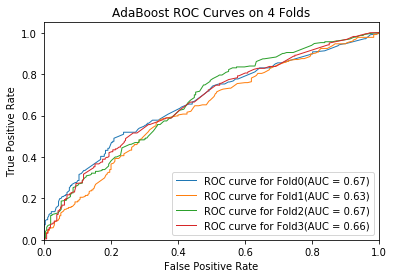

In [61]:
#Plot ROC curves for all folds 
for i, fold_info in enumerate(folds_performance): 
    plt.plot(fold_info["ada_fpr"], fold_info["ada_tpr"],
             label='ROC curve for Fold'+ str(i) + '(AUC = {0:0.2f})'.format(fold_info["ada_auc"]),
             linewidth=1)

plt.title('AdaBoost ROC Curves on 4 Folds')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='best')
plt.show()


## Accuracy, AUC

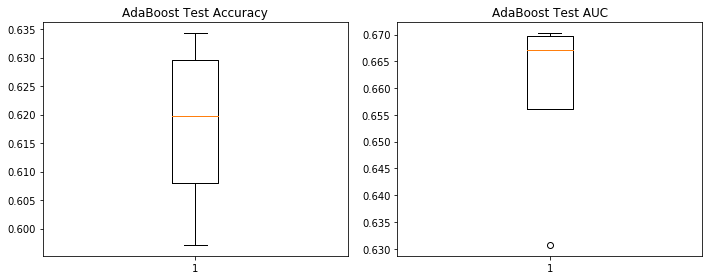

In [44]:
#Plot test acc, test AUC
ada_testacc_list, ada_testauc_list = [], []

for fold_info in folds_performance:
    ada_testacc_list.append(fold_info["ada_test_acc"])
    ada_testauc_list.append(fold_info["ada_auc"])

def boxplots(algorithm, test_acc, test_auc):
    #box plot using test accuracy 
    fig, (bp1_ax, bp2_ax) = plt.subplots(1,2, figsize=(10,4))
    bp1_ax.set_title(algorithm + " Test Accuracy")
    bp1_ax.boxplot(np.array(test_acc))

    #box plot using AUC
    bp2_ax.set_title(algorithm + " Test AUC")
    bp2_ax.boxplot(np.array(test_auc))

    plt.tight_layout()  
    plt.show()

boxplots("AdaBoost", ada_testacc_list, ada_testauc_list)

## Model reliance

In [60]:
#Compute error of AdaBoost test set
ada_error = 1 - AdaBoost_accuracy(X_train, Y_train,X_test, Y_test, feat_weights)[1]

model_reliance = []
col_labels = train_pd.columns.tolist()[1:]
for j in range(X_test.shape[1]): #iterate over features
    ada_avg_perm_error = 0

    #perform 10 shuffles of feature j and average the error obtained
    for k in range(10): 
        X_test_perm = np.copy(X_test)
        np.random.shuffle(X_test_perm[:,j])
        ada_avg_perm_error += ( 1 -  AdaBoost_accuracy(X_train, Y_train, X_test_perm, Y_test, feat_weights)[1])
    
    model_reliance.append([col_labels[j], ada_error - ada_avg_perm_error/10])
    
%store model_reliance 
print(tabulate(model_reliance, headers=["Feature", "AdaBoost"], floatfmt=".8f"))

Stored 'model_reliance' (list)
Feature                     AdaBoost
-----------------------  -----------
p_charge1                 0.00000000
p_charge3                 0.00000000
p_charge5                -0.00214477
p_charge7                 0.00000000
p_charge9                 0.00000000
p_jail30_1                0.00000000
p_jail30_3                0.00000000
p_jail30_5                0.00000000
p_jail30_7                0.00000000
p_jail30_9                0.00000000
p_prison1                 0.00428954
p_prison3                 0.00000000
p_prison5                 0.00000000
p_prison7                 0.00000000
p_prison9                 0.00000000
p_probation1              0.00000000
p_probation3              0.00000000
p_probation5              0.00455764
p_probation7             -0.00026810
p_probation9              0.00000000
p_juv_fel_count1          0.00000000
p_juv_fel_count3          0.00000000
p_juv_fel_count5          0.00000000
p_juv_fel_count7          0.00000000
p_juv_f

## Scoring Plots

(47, 77)
[0.01212445 0.01064754 0.01064754 0.01064754 0.00691198 0.00691198
 0.00691198 0.00691198 0.00589396 0.00589396 0.00589396 0.00589396
 0.00589396 0.00285641 0.00285641 0.00285641 0.00285641 0.00285641
 0.00285641 0.00285641 0.00285641 0.00285641 0.00285641 0.00285641
 0.00285641 0.00285641 0.00285641 0.00285641 0.00285641 0.00285641
 0.00285641 0.00285641 0.00218342 0.00218342 0.00218342 0.00218342
 0.00218342 0.00218342 0.00218342 0.00218342 0.00218342 0.00218342
 0.00172671 0.00172671 0.00172671 0.00172671 0.00172671]


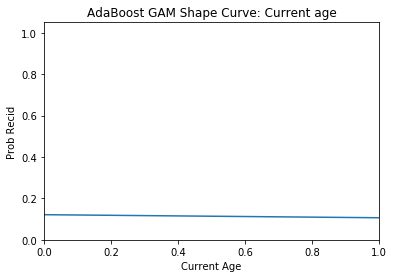

In [84]:
#idea: loop through features
#generate artificial data which has values for this only, plot adaboost probabilities

age_examples = np.ones((47,77))*-1
print(age_examples.shape)

for age in range(18, 65):
    age_examples[age-18, 55] = 1 if age <= 18 else -1
    age_examples[age-18, 56] = 1 if age <= 21 else -1
    age_examples[age-18, 57] = 1 if age <= 25 else -1
    age_examples[age-18, 58] = 1 if age <= 30 else -1
    age_examples[age-18, 59] = 1 if age <= 39 else -1
    age_examples[age-18, 60] = 1 if age <= 49 else -1
    age_examples[age-18, 61] = 1 if age <= 59 else -1
    
age_probas, _ = AdaBoost_predict(age_examples, feat_weights)
print(age_probas)
plt.plot(age_probas*10)
plt.title('AdaBoost GAM Shape Curve: Current age')
plt.xlabel('Current Age')
plt.ylabel('Prob Recid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.show()


In [81]:
print(feat_weights)

[1.12035121 0.         0.09097289 0.         0.         0.
 0.         0.         0.         0.         0.05538233 0.
 0.         0.         0.         0.         0.         0.04193969
 0.86997942 0.         0.         0.         0.         0.
 0.         0.         0.01433071 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02419291 0.11305691
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04655069 0.         0.         0.
 0.         0.03284715 0.10896027 0.04008829 0.18185376 0.
 0.06733709 0.05878317 0.         0.         0.         0.04878132
 0.         0.         0.         0.20531654 0.04544538 0.01373609
 0.         0.         0.         0.         0.        ]
